# Mask R-CNN Model Evaluation

In [4]:
import numpy as np
import os
import sys
import tensorflow as tf
from matplotlib import pyplot as plt
from PIL import Image

from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util
from object_detection.utils import ops as utils_ops

## 1. Crop Images to central 640x480 region

In [5]:
TEST_IMG_PATH = '/media/adam/HDD Storage/Datasets/supervisely-persons/ds1/img/bodybuilder-weight-training-stress-38630.png'

In [32]:
def crop_center(image, width, height):
    """
    Takes an image as a numpy array and crops to the centre region.
    
    Args:
        image: A numpy array of the image.
        width: The desired width of the cropped image.
        height: The desired height of the cropped image.

    Returns:
        image_crop: A numpy array of the cropped image.
    """
    if image.shape == 3:
        y, x, _ = image.shape
    elif len(image.shape) == 2:
        y, x = image.shape
    else:
        raise ValueError('Image must be stored in a 2D or 3D numpy array')

    start_x = x // 2 - (width // 2)
    start_y = y // 2 - (height // 2)
    image_crop = image[start_y:start_y + height, start_x:start_x + width]
    
    return image_crop

In [9]:
def load_image_into_numpy_array(image):
    """
    Load a PIL image into a numpy array.

    Args:
        image: A PIL image.

    Returns:
        array: A 2D numpy array of the image.
    """
    (im_width, im_height) = image.size
    array = np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

    return array

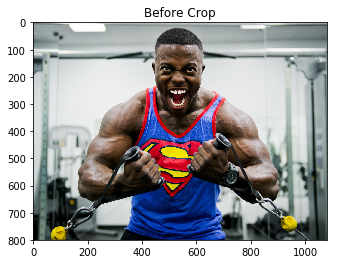

In [20]:
image = Image.open(TEST_IMG_PATH)
image_np = load_image_into_numpy_array(image)

# Before crop
plt.title('Before Crop')
plt.imshow(image_np)
plt.show()

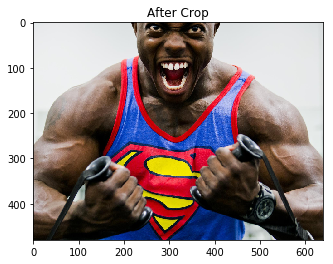

In [21]:
image_crop = crop_center(image_np, 640, 480)

# After crop
plt.title('After Crop')
plt.imshow(image_crop)
plt.show()

## 2. Test Model on an Image

In [2]:
# What model to download.
MODEL_NAME = 'mask_rcnn_inception_v2_supervisely_2018_03_31'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = os.path.join(os.getcwd(), 'models', MODEL_NAME, 'frozen_inference_graph.pb')

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join(os.getcwd(), 'data', 'persons_label_map.pbtxt')

NUM_CLASSES = 1

In [3]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

In [4]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [27]:
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    array = np.array(image.getdata()).reshape((im_height, im_width, -1)).astype(np.uint8)
    array = array[...,:3]
    return array

In [12]:
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
# PATH_TO_TEST_IMAGES_DIR = '/media/adam/HDD Storage/Datasets/supervisely-persons/ds1/img/bodybuilder-weight-training-stress-38630.png'
# TEST_IMAGE_PATHS = ['/media/adam/HDD Storage/Datasets/supervisely-persons/ds1/img/bodybuilder-weight-training-stress-38630.png']
TEST_IMAGE_PATHS = [os.path.join(os.getcwd(), 'data', 'single_frame.png')]
print(TEST_IMAGE_PATHS)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

['/home/adam/Development/pedestrian-proximity-detector/data/single_frame.png']


In [25]:
def run_inference_for_single_image(image, graph):
    with graph.as_default():
        config = tf.ConfigProto()
#         config.gpu_options.allow_growth = True
        config.gpu_options.per_process_gpu_memory_fraction = 0.4
        sess = tf.Session(config=config)
        # Get handles to input and output tensors
        ops = tf.get_default_graph().get_operations()
        all_tensor_names = {output.name for op in ops for output in op.outputs}
        tensor_dict = {}
        for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
        ]:
            tensor_name = key + ':0'
            if tensor_name in all_tensor_names:
              tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                  tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[1], image.shape[2])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
                image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

                # Run inference
                output_dict = sess.run(tensor_dict,
                                     feed_dict={image_tensor: image})

                # all outputs are float32 numpy arrays, so convert types as appropriate
                output_dict['num_detections'] = int(output_dict['num_detections'][0])
                output_dict['detection_classes'] = output_dict[
                  'detection_classes'][0].astype(np.uint8)
                output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
                output_dict['detection_scores'] = output_dict['detection_scores'][0]
                if 'detection_masks' in output_dict:
                    output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

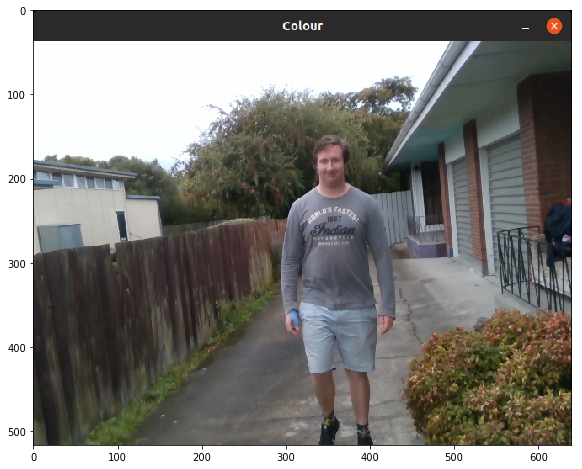

In [28]:
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)
  # Visualization of the results of a detection.
#   vis_util.visualize_boxes_and_labels_on_image_array(
#       image_np,
#       output_dict['detection_boxes'],
#       output_dict['detection_classes'],
#       output_dict['detection_scores'],
#       category_index,
#       instance_masks=output_dict.get('detection_masks'),
#       use_normalized_coordinates=True,
#       line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)

In [32]:
masks = output_dict.get('detection_masks')
if len(masks) > 0:
    h, w = masks[0].shape
    mask = masks[0].reshape(h, w)
    plt.imshow('Segmentation', mask)